In [1]:
import pandas as pd
import numpy as np
import datetime 

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show, output_notebook, output_file, save
from bokeh.palettes import Category20c
from bokeh.transform import factor_cmap
from bokeh.layouts import Row, Column
from bokeh.models import BoxSelectTool, NumeralTickFormatter

output_notebook()

Loading BokehJS ...

In [2]:
fashion_df = pd.read_csv('../data/user_reviews.csv', index_col=0)
#fashion_df.head()

In [3]:
fashion_df['reviewTime'] = pd.to_datetime(fashion_df['reviewTime'], format = '%m %d, %Y')
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358003 entries, B00APT3MHO to B00C5W5Z0G
Data columns (total 9 columns):
helpful           358003 non-null object
overall           358003 non-null float64
productid         358003 non-null int64
reviewText        357988 non-null object
reviewTime        358003 non-null datetime64[ns]
reviewerID        358003 non-null object
reviewerName      357722 non-null object
summary           358001 non-null object
unixReviewTime    358003 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 27.3+ MB


In [4]:
items_df = pd.read_csv('../data/items.csv')
#items_df.head()

In [5]:
items = items_df[['asin','title','price','categories','brand']]
data_df = fashion_df.merge(items, left_on='asin', right_on='asin', suffixes=('_left', '_right'))
data_df.head()

,asin,helpful,overall,productid,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,title,price,categories,brand
0,B00APT3MHO,"[0, 0]",5.0,1,Good for someone who likes skinny jeans but do...,2013-11-17,A1JWX45KHE34AL,varnienarsil,Love these jeans,1384646400,Cheap Monday Women's Skinny Tight Jean,62.40,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",NaN
1,B00APT3MHO,"[0, 0]",3.0,1,I have never owned or tried on Cheap Monday je...,2013-08-10,A1IH8PZXP8B29W,KT,Runs small,1376092800,Cheap Monday Women's Skinny Tight Jean,62.40,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",NaN
2,B00CJ5NH36,"[0, 0]",5.0,2,This shirt with it's bold graphic is seriously...,2013-11-17,A1JWX45KHE34AL,varnienarsil,As cute as it looks,1384646400,ELLAZHU Women Crew Neck Crane &amp; Fox Short ...,20.95,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",NaN
3,B00F9NGAPM,"[1, 1]",3.0,4,The shirt is a little flowy-er than I expected...,2013-11-17,A1JWX45KHE34AL,varnienarsil,"Like, don't love",1384646400,ELLAZHU Women Baggy Diagonal Stripes Long Slee...,NaN,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",NaN
4,B000LYFF46,"[0, 0]",3.0,5,"I selected &#34;fit as expected&#34;, but they...",2014-03-03,A2YHF6O2D37PMX,DCP,Just not comfortable for me,1393804800,Naturalizer Women's Barnett Sneaker,NaN,"[['Clothing, Shoes & Jewelry', 'Shoes & Access...",NaN


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358003 entries, 0 to 358002
Data columns (total 14 columns):
asin              358003 non-null object
helpful           358003 non-null object
overall           358003 non-null float64
productid         358003 non-null int64
reviewText        357988 non-null object
reviewTime        358003 non-null datetime64[ns]
reviewerID        358003 non-null object
reviewerName      357722 non-null object
summary           358001 non-null object
unixReviewTime    358003 non-null int64
title             357932 non-null object
price             72366 non-null float64
categories        358003 non-null object
brand             4553 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 41.0+ MB


# Overall Rating

In [7]:
product = data_df.groupby(['overall'])['productid'].count().reset_index().rename(columns = {'productid':'frequency'}).sort_values(by='frequency', ascending=False)
freq = pd.DataFrame(product)
freq.head()

,overall,frequency
4,5.0,194856
3,4.0,78043
2,3.0,44792
1,2.0,24075
0,1.0,16237


In [109]:
from bokeh.core.properties import value

cds_freq = ColumnDataSource(freq)
cds_freq.column_names

['index', 'overall', 'frequency']

In [9]:
rate_bar = figure(height=400, width=950,
                  title="Overall Rating Distribution",
                  x_axis_label = 'Frequency',
                  y_axis_label = 'Overall Rating',
                  # y_range=building.BuildingType.unique(),
                  tools=['lasso_select,box_select,pan,reset,tap'])

rate_bar.hbar(right='frequency', y='overall', 
              height=.5, source=cds_freq)

rate_bar.xaxis.formatter = NumeralTickFormatter(format="1,000")

rate_hover = HoverTool(tooltips=[("Number of Reviews","@frequency")])
rate_bar.add_tools(rate_hover)

show(rate_bar)

In [10]:
save(rate_bar, filename="overall-rating.html", title='overall')

C:\Users\khanhdi\Anaconda3\lib\site-packages\bokeh\io\saving.py:127: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


'D:\\2019 Spring Baruch\\Columbia Engineering\\FinalProject\\project-clorec\\src\\overall-rating.html'

# Product Popularity versus Rating and Review Length

In [11]:
rating = data_df.groupby(['productid','title','summary','reviewText','brand'])\
            .agg({'overall':'mean','asin':'count'})\
            .reset_index()\
            .rename(columns = {'overall':'rating_average','asin':'times_sold'})\
            .sort_values(by=['rating_average','times_sold'], ascending=False)

product_rating = pd.DataFrame(rating)

counting = []

for review in product_rating['reviewText']:
    counting.append(len(review))
product_rating['word_count'] = pd.Series(counting)

In [12]:
group_product = product_rating.groupby(['productid','title','brand'])\
        .agg({'word_count':'mean','times_sold':'sum','rating_average':'mean'})\
        .reset_index()
counting_rating = pd.DataFrame(group_product)
counting_rating.head()

,productid,title,brand,word_count,times_sold,rating_average
0,112,Allegra K Women's Round Neck Batwing Sleeve Se...,Allegra K,243.181818,22,4.045455
1,113,Allegra K Women's Round Neck Batwing Sleeve Se...,Allegra K,300.105263,19,4.473684
2,114,Allegra K Women's Round Neck Batwing Sleeve Se...,Allegra K,260.846154,26,3.807692
3,202,Not Rated Women's Warm Up Knee-High Boot,Not Rated,232.000000,13,4.307692
4,230,NSSTAR Womens Polka Dots Long Boho Chiffon Dress,NSSTAR,421.909091,22,3.681818


In [13]:
cds_rating = ColumnDataSource(counting_rating)
cds_rating.column_names

['index',
 'productid',
 'title',
 'brand',
 'word_count',
 'times_sold',
 'rating_average']

In [26]:
rate_scatter = figure(height=400, width=440,
                      title="Popularity versus Rating Average",
                      x_axis_label = 'Rating Average',
                      y_axis_label = 'Number of Items Sold',
                      x_axis_type="linear",
                      tools=['lasso_select,box_select,box_zoom,wheel_zoom,pan,reset,tap'])

rate_scatter.circle(x='rating_average', y='times_sold', size=5,
                    color='coral', alpha=0.4, source=cds_rating)

word_scatter = figure(height=400, width=440,
                      title="Popularity versus Word Count",
                      x_axis_label = 'Word Count',
                      y_axis_label = 'Number of Items Sold',
                      x_axis_type="linear",
                      tools=['lasso_select,box_select,box_zoom,wheel_zoom,pan,reset,tap'])

word_scatter.x_range.end = 6000

word_scatter.circle(x='word_count', y='times_sold', size=5,
                    color='green', alpha=0.4, source=cds_rating)

rate_hover = HoverTool(tooltips=[
    ("Product","@title"),
    ("Brand","@brand"),
    ("Rating","@rating_average")])

rate_scatter.add_tools(rate_hover)
word_scatter.add_tools(rate_hover)

show(Row(rate_scatter,word_scatter))

In [27]:
save(rate_scatter, filename="rate-scatter.html", title="rate-scatter")
save(word_scatter, filename="word-scatter.html", title="word-scatter")

C:\Users\khanhdi\Anaconda3\lib\site-packages\bokeh\io\saving.py:127: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


'D:\\2019 Spring Baruch\\Columbia Engineering\\FinalProject\\project-clorec\\src\\word-scatter.html'

# Reviewers Activity Summary

In [16]:
data_df['year'] = data_df['reviewTime'].apply(lambda x: x.year)
data_df['month'] = data_df['reviewTime'].apply(lambda x: x.month)

reviews = data_df.groupby(['year','reviewTime'])\
                 .agg({'productid':'count','brand':'nunique'})\
                 .reset_index().rename(columns={'productid':'Reviews','brand':'Brands'})
reviews_df = pd.DataFrame(reviews)
reviews_df['ReviewsPerBrand'] = reviews_df['Reviews']/reviews_df['Brands']
reviews_df.tail()

,year,reviewTime,Reviews,Brands,ReviewsPerBrand
2965,2014,2014-07-19,384,5,76.800000
2966,2014,2014-07-20,317,6,52.833333
2967,2014,2014-07-21,458,6,76.333333
2968,2014,2014-07-22,441,9,49.000000
2969,2014,2014-07-23,75,1,75.000000


In [17]:
cds_review = ColumnDataSource(reviews_df)
cds_review.column_names

['index', 'year', 'reviewTime', 'Reviews', 'Brands', 'ReviewsPerBrand']

In [18]:
review_chart = figure(height=500, width=950,
                      title="Total Reviews of Time",
                      x_axis_label= "Time", 
                      y_axis_label= "Number of Reviews",
                      x_axis_type="datetime",
                      tools=['lasso_select,box_select,pan,reset,tap'])

review_chart.line(x='reviewTime', y='Reviews', 
                  legend=value('Reviews'), alpha=0.6,
                  line_width=3, line_color='coral', source=cds_review)
review_chart.line(x='reviewTime', y='ReviewsPerBrand', 
                  legend=value('ReviewsPerBrand'), alpha=0.6,
                  line_width=3, line_color='indigo', source=cds_review)

review_hover = HoverTool(tooltips=[
    ("No. of Review","@Reviews"),
    ("Year","@year")])

review_chart.add_tools(review_hover)

show(review_chart)

In [19]:
save(review_chart, filename="reviews-over-time.html", title='review')

'D:\\2019 Spring Baruch\\Columbia Engineering\\FinalProject\\project-clorec\\src\\reviews-over-time.html'

# Recommendation Engine Visualization

In [20]:
x_label = 'No. of Recommendations'
y_label = 'Recall Value (%)'

rec_num = [10,25,50,100]
SVD_100 = [1.31,2,2.63,3.77]
SVD_50 = [1.08,1.97,2.71,3.84]
IMF = [2.22,3.32,4.53,6.27]
TFIDF = [0.41,1.15,2.01,3.38]
Baseline = [0.66,1.15,1.8,2.75]

rec = pd.DataFrame()
rec['num'] = rec_num
rec['svd_100'] = SVD_100
rec['svd_50'] = SVD_50
rec['imf'] = IMF
rec['tfidf'] = TFIDF
rec['baseline'] = Baseline

rec.head()

,num,svd_100,svd_50,imf,tfidf,baseline
0,10,1.31,1.08,2.22,0.41,0.66
1,25,2.00,1.97,3.32,1.15,1.15
2,50,2.63,2.71,4.53,2.01,1.80
3,100,3.77,3.84,6.27,3.38,2.75


In [21]:
cds_rec = ColumnDataSource(rec)
cds_rec.column_names

['index', 'num', 'svd_100', 'svd_50', 'imf', 'tfidf', 'baseline']

In [22]:
rec_chart = figure(height=450, width=950,
                   title="Recommendation System Models Comparison",
                   x_axis_label=x_label, y_axis_label=y_label,
                   x_axis_type="linear",
                   tools=['lasso_select,box_select,pan,reset,tap'])

rec_chart.line(x='num',y='svd_100',line_width=2, alpha=0.6,
               legend=value('svd_100'),
               line_color='coral',source=cds_rec)
rec_chart.circle(x='num',y='svd_100',size=4, alpha=0.6,
                 color='gray',legend=value('svd_100'),source=cds_rec)

rec_chart.line(x='num',y='svd_50',line_width=2, alpha=0.6,
               legend=value('svd_50'),
               line_color='green',source=cds_rec)
rec_chart.circle(x='num',y='svd_50',size=4, alpha=0.6,
                 color='gray',legend=value('svd_50'),source=cds_rec)

rec_chart.line(x='num',y='imf',line_width=2, alpha=0.6,
               legend=value('imf'),
               line_color='indigo',source=cds_rec)
rec_chart.circle(x='num',y='imf',size=4, alpha=0.6,
                 color='gray',legend=value('imf'),source=cds_rec)

rec_chart.line(x='num',y='tfidf',line_width=2, alpha=0.6,
               legend=value('tfidf'),
               line_color='tomato',source=cds_rec)
rec_chart.circle(x='num',y='tfidf',size=4, alpha=0.6,
                 color='gray',legend=value('tfidf'),source=cds_rec)

rec_chart.line(x='num',y='baseline',line_width=2, alpha=0.6,
               legend=value('baseline'),
               line_color='midnightblue',source=cds_rec)
rec_chart.circle(x='num',y='baseline',size=4, alpha=0.6,
                 color='gray',legend=value('baseline'),source=cds_rec)

rec_hover = HoverTool(tooltips=[
    ("No. of Rec","@num")
])

rec_chart.add_tools(rec_hover)

rec_chart.legend.click_policy = "hide"
rec_chart.legend.location = "bottom_right"

show(rec_chart)

In [23]:
save(rec_chart, filename="rec-models.html", title='rec-models')

'D:\\2019 Spring Baruch\\Columbia Engineering\\FinalProject\\project-clorec\\src\\rec-models.html'

# Final Dashboard

In [28]:
show(Column(rate_bar,Row(rate_scatter,word_scatter),review_chart))

# Wordcloud

In [95]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [42]:
cloud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358003 entries, 0 to 358002
Data columns (total 4 columns):
reviewerID    358003 non-null object
asin          358003 non-null object
overall       358003 non-null float64
reviewText    357988 non-null object
dtypes: float64(1), object(3)
memory usage: 23.7+ MB


In [46]:
cloud = data_df[['reviewerID','asin','overall','reviewText']]
cloud_positive = cloud.loc[cloud['overall'] == 5]
cloud_positive.head()

,reviewerID,asin,overall,reviewText
0,A1JWX45KHE34AL,B00APT3MHO,5.0,Good for someone who likes skinny jeans but do...
2,A1JWX45KHE34AL,B00CJ5NH36,5.0,This shirt with it's bold graphic is seriously...
8,A2UP9MFSG6XU9B,B000LYFF46,5.0,Ok what more can I say than perfect. Bought AL...
9,A2H1PDX22BPBP9,B000LYFF46,5.0,I am buying shoes for comfort and good looks a...
10,A2QR6OWLL974G6,B000LYFF46,5.0,all i can say is thank G-d for these shoes so ...


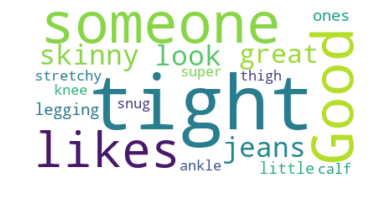

In [47]:
text = cloud_positive.reviewText[0]
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
def transform_format(val):
    if val == 0:
        val = 255
    return val

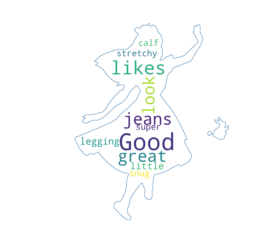

<Figure size 432x288 with 0 Axes>

In [93]:
alice_mask = np.array(Image.open("../data/alice.png"))

stopwords = set(STOPWORDS)
stop_list = ["said","tight","someone","skinny","ones","ankle","knee","thigh"]
for word in stop_list:
    stopwords.add(word)

wc = WordCloud(background_color="white", max_words=10000, 
               mask=alice_mask, scale=3,
               stopwords=stopwords, 
               width=900,height=900,
               contour_width=5, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
# wc.to_file("alice.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

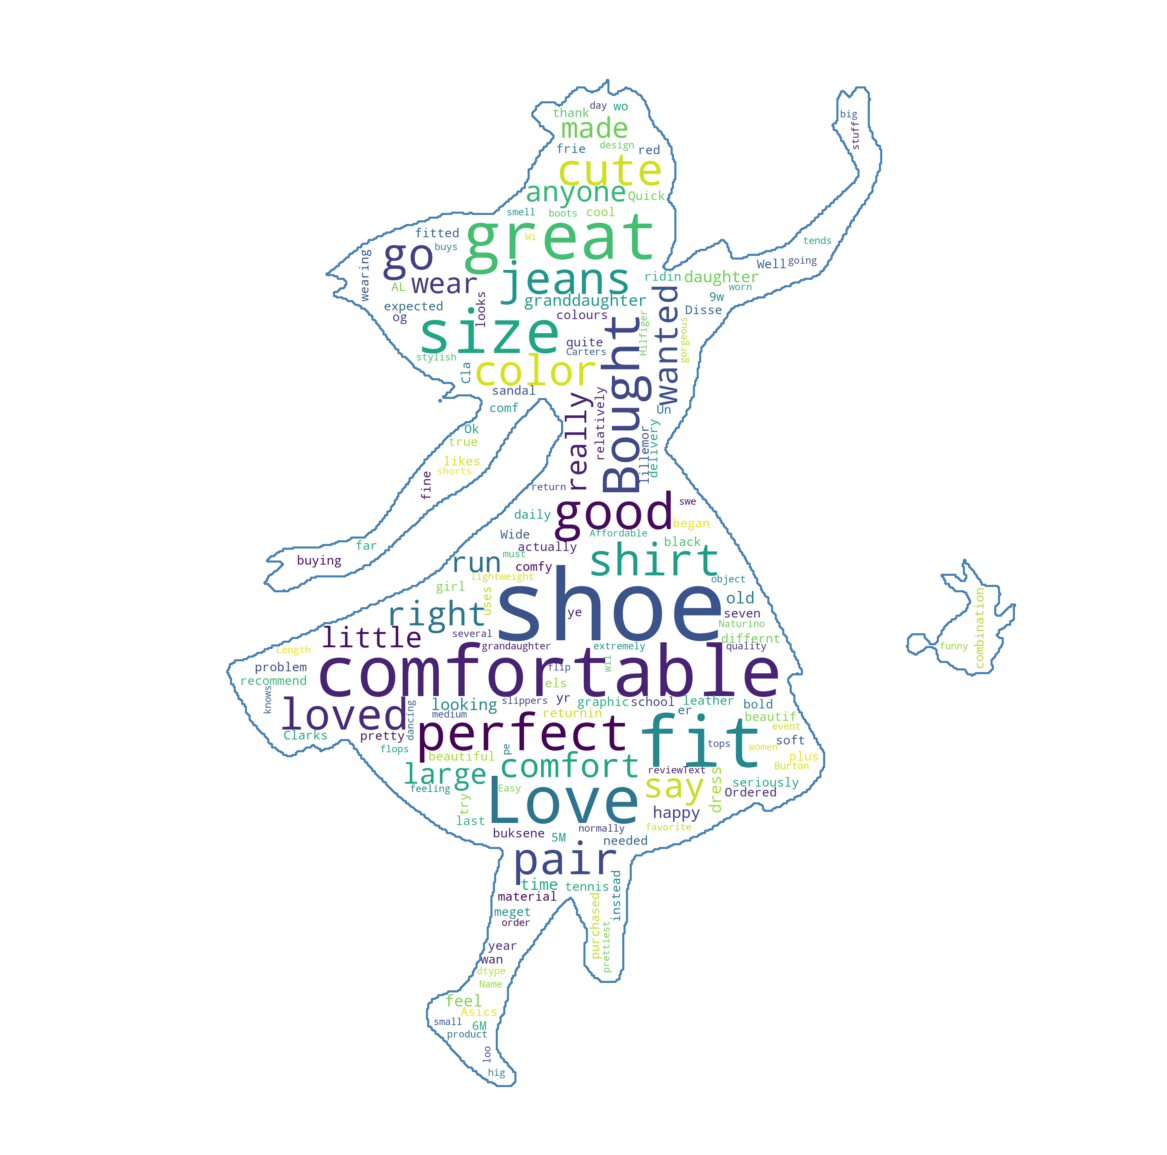

In [103]:
stopwords = set(STOPWORDS)
stop_list = ["said","tight","someone","skinny","ones","ankle","knee","thigh"]
for word in stop_list:
    stopwords.add(word)


mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=80, 
        scale=3, mask=alice_mask,
        contour_width=5, contour_color='steelblue',
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data)).to_file("alice.png")
    
    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    
show_wordcloud(cloud_positive["reviewText"])

In [ ]:
dress_mask = np.array(Image.open("../data/tall-dress.png"))
dress_mask.shape

# Sentiments Testing

In [139]:
reviewText = ["Heavenly Highway Hymns",
              "Not disappointed",
              "Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!",
              "Nasty smelling shampoo!."]
negProb = [0.006188,0.017109,0.993196,0.675717]
posProb = [0.993812,0.982891,0.006804,0.324283]

sense = pd.DataFrame()
sense['review'] = reviewText
sense['negative'] = negProb
sense['positive'] = posProb

sense.head()

,review,negative,positive
0,Heavenly Highway Hymns,0.006188,0.993812
1,Not disappointed,0.017109,0.982891
2,Very oily and creamy. Not at all what I expect...,0.993196,0.006804
3,Nasty smelling shampoo!.,0.675717,0.324283


In [140]:
cds_sense = ColumnDataSource(sense)
cds_sense.column_names

['index', 'review', 'negative', 'positive']

In [142]:
sense_plot = figure(title="Test Sentiment Analysis (Hover to check)", 
              plot_width=500, plot_height=500,
              min_border=0, toolbar_location=None)

sense_plot.vbar(x='index', bottom=0, top='negative', 
          legend=value('negative'), alpha=0.8,
          width=0.5, source=cds_sense)
sense_plot.vbar(x='index', bottom='negative', 
          legend=value('positive'), alpha=0.8,
          top=1, width=0.5, source=cds_sense, color='orange')

sense_plot.x_range.end = 5

sense_hover = HoverTool(tooltips=[
    ("Review","@review"),
    ("Positive Probability","@positive"),
    ("Negative Probability","@negative")
])

sense_plot.add_tools(sense_hover)


show(sense_plot)

In [143]:
save(sense_plot, filename="sentiment-results.html", title="sentiment")

C:\Users\khanhdi\Anaconda3\lib\site-packages\bokeh\io\saving.py:127: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


'D:\\2019 Spring Baruch\\Columbia Engineering\\FinalProject\\project-clorec\\src\\sentiment-results.html'